In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-r76mmad2
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-r76mmad2
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101076 sha256=bc3cd1c229d1a19e0e01e55083f4ce3c47286a6cade5afb711406ec7b7d795ef
  Stored in directory: /tmp/pip-ephem-wheel-cache-ekprgxhc/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


Model Definition (1. Discriminator 2. Generator 3. Composite Model)

In [7]:
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Convolution2D
from keras.layers import LeakyReLU
from keras.layers import MaxPool2D
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from tensorflow.keras.utils import plot_model

In [8]:
# define the discriminator model
def PatchGAN_Discriminator():
  # weight initialization
  init = RandomNormal(stddev=0.001)
  image_shape =(256,256,3)
  # source image input
  in_image = Input(shape=image_shape)
  # C64
  d1 = Convolution2D(64, (4,4), padding='same', kernel_initializer=init)(in_image)
  d1 = LeakyReLU(alpha=0.6)(d1)
  d1 = MaxPool2D(pool_size=(1,1), strides= 2)(d1)
  # C128
  d2 = Convolution2D(128, (4,4), padding='same', kernel_initializer=init)(d1)
  d2 = InstanceNormalization(axis=-1)(d2)
  d2 = LeakyReLU(alpha=0.6)(d2)
  d2 = MaxPool2D(pool_size=(1,1), strides= 2)(d2)
  # C256
  d3 = Convolution2D(256, (4,4), padding='same', kernel_initializer=init)(d2)
  d3 = InstanceNormalization(axis=-1)(d3)
  d3 = LeakyReLU(alpha=0.6)(d3)
  d3 = MaxPool2D(pool_size=(1,1), strides= 2)(d3)
  
  # C512
  d4 = Convolution2D(512, (4,4), padding ='same', kernel_initializer=init)(d3)
  d4 = InstanceNormalization(axis=-1)(d4)
  d4 = LeakyReLU(alpha=0.6)(d4)
  d4 = MaxPool2D(pool_size=(2,2), strides= 1)(d4)
 
  # patch output
  d5 = Convolution2D(1, (4,4), padding= 'same',  kernel_initializer=init)(d4)
  patch_out=  MaxPool2D(pool_size=(2,2), strides= 1)(d5)
  # define model
  model = Model(in_image, patch_out)
  # compile model
  model.compile(loss='mse', optimizer=Adam(learning_rate=0.00015, beta_1=0.85), loss_weights=[0.5])
  return model

In [6]:
# define image shape
image_shape = (256,256,3)
# create the model
discr = PatchGAN_Discriminator()
# summarize the model
discr.summary()
#plot the model
#plot_model(discr, to_file='discriminator_model_plot.png', show_shapes=True,show_layer_names=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     131200    
_________________________________________________________________
instance_normalization (Inst (None, 128, 128, 128)     256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 128)     0     

In [28]:
from keras.layers import UpSampling2D
from keras.layers import Dropout
from keras.layers import concatenate
from keras.layers import Activation

In [29]:
# Define the Generator Model
def UNET_Generator():
    input_shape = (256, 256, 3)
    input_image = Input(shape=input_shape)

    #Encoder Part
    #E1
    encoder1 = Convolution2D(filters=64, kernel_size= 3, padding='same', strides= 2)(input_image)
    encoder1 = LeakyReLU(alpha= 0.6)(encoder1)
    #E2
    encoder2 = Convolution2D(filters=128, kernel_size= 3, padding='same', strides= 2)(encoder1)
    encoder2 = InstanceNormalization()(encoder2)
    encoder2 = LeakyReLU(alpha= 0.6)(encoder2)
    #E3
    encoder3 = Convolution2D(filters=256, kernel_size= 3, padding='same', strides= 2)(encoder2)
    encoder3 = InstanceNormalization()(encoder3)
    encoder3 = LeakyReLU(alpha= 0.6)(encoder3)
    #E4
    encoder4 = Convolution2D(filters=512, kernel_size= 3, padding='same', strides= 2)(encoder3)
    encoder4 = InstanceNormalization()(encoder4)
    encoder4 = LeakyReLU(alpha= 0.6)(encoder4)
    #E5
    encoder5 = Convolution2D(filters=512, kernel_size= 3, padding='same', strides= 2)(encoder4)
    encoder5 = InstanceNormalization()(encoder5)
    encoder5 = LeakyReLU(alpha= 0.6)(encoder5)
    #E6
    encoder6 = Convolution2D(filters=512, kernel_size= 3, padding='same', strides= 2)(encoder5)
    encoder6 = InstanceNormalization()(encoder6)
    encoder6 = LeakyReLU(alpha= 0.6)(encoder6)
    #E7
    encoder7 = Convolution2D(filters=512, kernel_size= 3, padding='same', strides= 2)(encoder6)
    encoder7 = InstanceNormalization()(encoder7)
    encoder7 = LeakyReLU(alpha= 0.6)(encoder7)
    #E8
    encoder8 = Convolution2D(filters=512, kernel_size= 3, padding='same', strides= 2)(encoder7)
    encoder8 = InstanceNormalization()(encoder8)
    encoder8 = LeakyReLU(alpha= 0.6)(encoder8)

    # Decoder Part
    #D1
    decoder1 = UpSampling2D(size= 2)(encoder8)
    decoder1 = Convolution2D(filters=512, kernel_size= 3, padding='same')(decoder1)
    decoder1 = InstanceNormalization()(decoder1)
    decoder1 = Dropout(0.3)(decoder1)
    decoder1 = concatenate([decoder1, encoder7], axis=3)
    decoder1 = Activation('relu')(decoder1)
    #D2
    decoder2 = UpSampling2D(size= 2)(decoder1)
    decoder2 = Convolution2D(filters=1024, kernel_size= 3, padding='same')(decoder2)
    decoder2 = InstanceNormalization()(decoder2)
    decoder2 = Dropout(0.4)(decoder2)
    decoder2 = concatenate([decoder2, encoder6])
    decoder2 = Activation('relu')(decoder2)
    #D3
    decoder3 = UpSampling2D(size= 2)(decoder2)
    decoder3 = Convolution2D(filters=1024, kernel_size= 3, padding='same')(decoder3)
    decoder3 = InstanceNormalization()(decoder3)
    decoder3 = Dropout(0.4)(decoder3)
    decoder3 = concatenate([decoder3, encoder5])
    decoder3 = Activation('relu')(decoder3)
    #D4
    decoder4 = UpSampling2D(size= 2)(decoder3)
    decoder4 = Convolution2D(filters=1024, kernel_size= 3, padding='same')(decoder4)
    decoder4 = InstanceNormalization()(decoder4)
    decoder4 = concatenate([decoder4, encoder4])
    decoder4 = Activation('relu')(decoder4)
    #D5
    decoder5 = UpSampling2D(size= 2)(decoder4)
    decoder5 = Convolution2D(filters=1024, kernel_size= 3, padding='same')(decoder5)
    decoder5 = InstanceNormalization()(decoder5)
    decoder5 = concatenate([decoder5, encoder3])
    decoder5 = Activation('relu')(decoder5)
    #D6
    decoder6 = UpSampling2D(size= 2)(decoder5)
    decoder6 = Convolution2D(filters=512, kernel_size= 3, padding='same')(decoder6)
    decoder6 = InstanceNormalization()(decoder6)
    decoder6 = concatenate([decoder6, encoder2])
    decoder6 = Activation('relu')(decoder6)
    #D7
    decoder7 = UpSampling2D(size= 2)(decoder6)
    decoder7 = Convolution2D(filters=256, kernel_size= 3, padding='same')(decoder7)
    decoder7 = InstanceNormalization()(decoder7)
    decoder7 = concatenate([decoder7, encoder1])
    decoder7 = Activation('relu')(decoder7)
    #D8 The Last One
    decoder8 = UpSampling2D(size= 2)(decoder7)
    decoder8 = Convolution2D(filters= 3, kernel_size= 3, padding='same')(decoder8)
    decoder8 = Activation('tanh')(decoder8)

    model = Model(inputs=[input_image], outputs=[decoder8])
    return model

In [9]:
generator = UNET_Generator()
# sumgenemarize the model
generator.summary()
#plot the model
#plot_model(generator, to_file='Generator_model_plot.png', show_shapes=True,show_layer_names=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 128)  73856       leaky_re_lu_4[0][0]              
____________________________________________________________________________________________

In [10]:
# Define Composite Model(updating generators by adversarial and cycle loss)
def Composite(g_model_1, d_model, g_model_2, image_shape):
   # First Generator is Trainable
  g_model_1.trainable = True
  # Discriminator is not Trainable
  d_model.trainable = False
  # Second Generator is not Trainable
  g_model_2.trainable = False

  # Things in Discriminator
  input_gen = Input(shape=image_shape)
  gen1_out = g_model_1(input_gen)
  output_d = d_model(gen1_out)
  
  # identity element
  input_id = Input(shape=image_shape)
  output_id = g_model_1(input_id)
  
  # Forward Cycle
  output_f = g_model_2(gen1_out)

  # Backward Cycle
  gen2_out = g_model_2(input_id)
  output_b = g_model_1(gen2_out)

  # Define Model Graph
  model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
  # Algorithm Optimization Parameters
  opt = Adam(learning_rate=0.0002, beta_1=0.85)

  # Compile Model with Optimizer and Loss functions
  model.compile(loss=['mse','mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
  return model

In [11]:
import time
from glob import glob
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from keras.layers import Lambda, Reshape
import tensorflow as tf
from keras.callbacks import TensorBoard
from matplotlib import pyplot
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray

In [12]:
from google.colab import files
files.upload() # load kaggle.json file from this computer

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"balnyaupane","key":"6575a2f65f6d42cfd16dadbf6866a8f9"}'}

In [13]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#Change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [14]:
!kaggle datasets download -d balraj98/summer2winter-yosemite -p /content

 95% 120M/126M [00:01<00:00, 64.3MB/s] 
100% 126M/126M [00:01<00:00, 95.5MB/s]


In [15]:
import zipfile
!unzip -uq "/content/summer2winter-yosemite.zip" -d "/content/Dataset"

In [16]:
def load_images(data_dir):
    imagesA = glob(data_dir + '/trainA/*.*')
    imagesB = glob(data_dir + '/trainB/*.*')

    allImagesA = []
    allImagesB = []

    for index, filename in enumerate(imagesA):
        imgA = imread(filename, pilmode='RGB')        

        imgA = resize(imgA, (256, 256))
        

        if np.random.random() > 0.5:
            imgA = np.fliplr(imgA)
            

        allImagesA.append(imgA)
        

    for index, filename in enumerate(imagesB):
        imgB = imread(filename, pilmode='RGB')      

        imgB = resize(imgB, (256, 256))

        if np.random.random() > 0.5:
            imgB = np.fliplr(imgB)

        
        allImagesB.append(imgB)

    # Normalize images
    allImagesA = np.array(allImagesA)
    allImagesB = np.array(allImagesB)

    return allImagesA, allImagesB

In [17]:
def load_test(data_dir, batch_size):
    imagesA = glob(data_dir)
    

    imagesA = np.random.choice(imagesA, batch_size)
  

    allA = []


    for index, filename in enumerate(imagesA):
        imgA = imread(filename, pilmode='RGB')        

        imgA = resize(imgA, (256, 256))
     

        allA.append(imgA)


    return np.array(allA) 

In [18]:
data_dir = "/content/Dataset"

In [19]:
trainA, trainB = load_images(data_dir=data_dir)

In [20]:
from numpy.random import randint
from numpy import zeros
from numpy import ones
from numpy import asarray
from random import random
from numpy import load
from matplotlib import pyplot as plt

In [21]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
  # choose random instances
  ix = randint(0, dataset.shape[0], n_samples)
  # retrieve selected images
  X = dataset[ix]
  # generate ✬real✬ class labels (1)
  y = ones((n_samples, patch_shape, patch_shape, 1))
  return X, y

In [22]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
  # generate fake instance
  X = g_model.predict(dataset)
  # create fake class labels (0)
  y = zeros((len(X), patch_shape, patch_shape, 1))
  return X, y

In [23]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, path, n_samples=10):
  # select a sample of input images
  X_in, _ = generate_real_samples(trainX, n_samples, 0)
  # generate translated images
  X_out, _ = generate_fake_samples(g_model, X_in, 0)
  # scale all pixels from [-1,1] to [0,1]
  #X_in = (X_in + 1) / 2.0
  #X_out = (X_out + 1) / 2.0
  # plot real images
  #plt.fig(dpi=600)
  for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(X_in[i])
    plt.show()
  # plot translated image
  for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(X_out[i])
    plt.show()
  # save plot to file
  #filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
  #plt.savefig(path)
  #plt.close()
  #pyplot.close()

In [24]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
  selected = list()
  for image in images:
    if len(pool) < max_size:
      # stock the pool
      pool.append(image)
      selected.append(image)
    elif random() < 0.5:
      # use image, but don✬t add it to the pool
      selected.append(image)
    else:
      # replace an existing image and use replaced image
      ix = randint(0, len(pool))
      selected.append(pool[ix])
      pool[ix] = image
  return asarray(selected)

In [ ]:
#D_A_loss1, D_A_loss2, D_B_loss1, D_B_loss2, G_A_loss1, G_B_loss2= list(),list(),list(),list(),list(),list()

In [25]:
def plot_history(dA_loss1, dA_loss2, dB_loss1, dB_loss2, g_loss1, g_loss2, path):
  # plot loss
  plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
  # plot discriminatorA loss
  plt.subplot(3, 1, 1)
  plt.plot(dA_loss1, label='Discriminator Loss for Real Image A')
  plt.plot(dA_loss2, label='Discriminator Loss for Generated Image A')
  plt.legend()

  # plot discriminatorB loss
  plt.subplot(3, 1, 2)
  plt.plot(dB_loss1, label='Discriminator Loss for Real Image B')
  plt.plot(dB_loss2, label='Discriminator Loss for Generated Image B')
  plt.legend()
	
  # plot generator loss
  plt.subplot(3, 1, 3)
  plt.plot(g_loss1, label='Loss for generator B->A ')
  plt.plot(g_loss2, label='Loss for generator A->B ')
  plt.legend()
  plt.show()
	# save plot to file
  #plt.savefig(path)
  #plt.close()

In [26]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
  
  D_A_loss1, D_A_loss2, D_B_loss1, D_B_loss2, G_A_loss1, G_B_loss2= list(),list(),list(),list(),list(),list()
  
  # define properties of the training run
  n_epochs, n_batch, = 32, 4
  # determine the output square shape of the discriminator
  n_patch = d_model_A.output_shape[1]
  # unpack dataset
  trainA, trainB = dataset
  # prepare image pool for fakes
  poolA, poolB = list(), list()
  # calculate the number of batches per training epoch
  bat_per_epo = int(len(trainA) / n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  # manually enumerate epochs
  for i in range(n_steps):
    # select a batch of real samples
    X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
    X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
    # generate a batch of fake samples
    X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
    X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
    # update fakes from pool
    X_fakeA = update_image_pool(poolA, X_fakeA)
    X_fakeB = update_image_pool(poolB, X_fakeB)
    # update generator B->A via adversarial and cycle loss
    g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
    # update discriminator for A -> [real/fake]
    dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
    dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
    # update generator A->B via adversarial and cycle loss
    g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB,X_realB, X_realA, X_realB])
    # update discriminator for B -> [real/fake]
    dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
    dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
    # summarize performance
    print('>>>>>>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))

    #append loss
    D_A_loss1.append(dA_loss1)
    D_A_loss2.append(dA_loss2)
    D_B_loss1.append(dB_loss1)
    D_B_loss2.append(dB_loss2)
    G_A_loss1.append(g_loss1)
    G_B_loss2.append(g_loss2)
   
   # evaluate the model performance every so often
    if (i) % 100 == 0:
      # plot A->B translation
      summarize_performance(i, g_model_AtoB, trainA, 'AtoB',path='/content/drive/MyDrive/AtoB_{}'.format(i+1100))
      # plot B->A translation
      summarize_performance(i, g_model_BtoA, trainB, 'BtoA',path='/content/drive/MyDrive/BtoA_{}'.format(i+1100))
      # Loss graph
      plot_history(D_A_loss1, D_A_loss2, D_B_loss1, D_B_loss2, G_A_loss1, G_B_loss2, path='/content/drive/MyDrive/loss.jpeg')

    if (i) % 100 == 0:
      #save  model
      g_model_BtoA.save_weights("/content/drive/MyDrive/g_BtoA_{}.h5".format(i+1100))
      g_model_AtoB.save_weights("/content/drive/MyDrive/g_AtoB_{}.h5".format(i+1100))
      d_model_A.save_weights("/content/drive/MyDrive/D_A_{}.h5".format(i+1100))
      d_model_B.save_weights("/content/drive/MyDrive/D_B_{}.h5".format(i+1100))

In [26]:
dataset = trainA, trainB
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

Loaded (1231, 256, 256, 3) (962, 256, 256, 3)


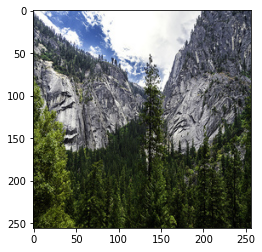

In [28]:
digit = trainA[4]
import matplotlib.pyplot as plt
plt.imshow(digit)
plt.show()

In [30]:
# generator: A -> B
g_model_AtoB = UNET_Generator()
# generator: B -> A
g_model_BtoA = UNET_Generator()
# discriminator: A -> [real/fake]
d_model_A = PatchGAN_Discriminator()
# discriminator: B -> [real/fake]
d_model_B = PatchGAN_Discriminator()

In [31]:
g_model_BtoA.load_weights("/content/drive/MyDrive/g_BtoA_4200.h5")
g_model_AtoB.load_weights("/content/drive/MyDrive/g_AtoB_4200.h5")
#d_model_A.load_weights("/content/drive/MyDrive/TheResult/D_A_1100.h5")
#d_model_B.load_weights("/content/drive/MyDrive/TheResult/D_B_1100.h5")


In [ ]:
# composite: A -> B -> [real/fake, A]
c_model_AtoB = Composite(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = Composite(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Output hidden; open in https://colab.research.google.com to view.

Test: [Summer to Winter]

In [42]:
data_dirSummer = '/content/drive/MyDrive/summerTest1.jpg'

In [43]:
test_imagestw = load_test(data_dirSummer, batch_size=1)

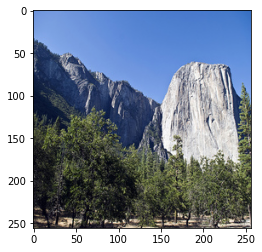

In [44]:
plt.imshow(test_imagestw[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


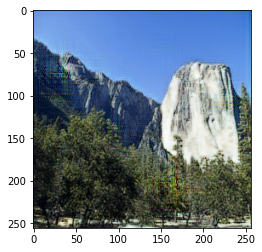

In [45]:
out= g_model_AtoB.predict(test_imagestw)
plt.imshow(out[0])
plt.show()

Test: [Winter to Summer]

In [37]:
data_dirWinter = '/content/drive/MyDrive/winterTest.jpg'

In [38]:
test_imagewts = load_test(data_dirWinter, batch_size=1)

In [39]:
outs = g_model_BtoA.predict(test_imagewts)

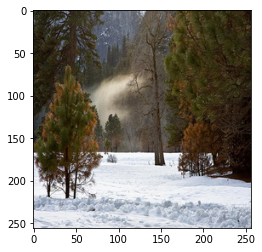

In [40]:
plt.imshow(test_imagewts[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


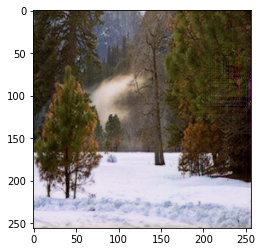

In [41]:
plt.imshow(outs[0])
plt.show()